In [85]:
%load_ext autoreload
%autoreload 2
import tile_tools
from IPython.display import SVG
import svgpathtools as spt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
file = 'source/test.svg'
paths, attributes, svg_attributes = spt.svg2paths2(file)

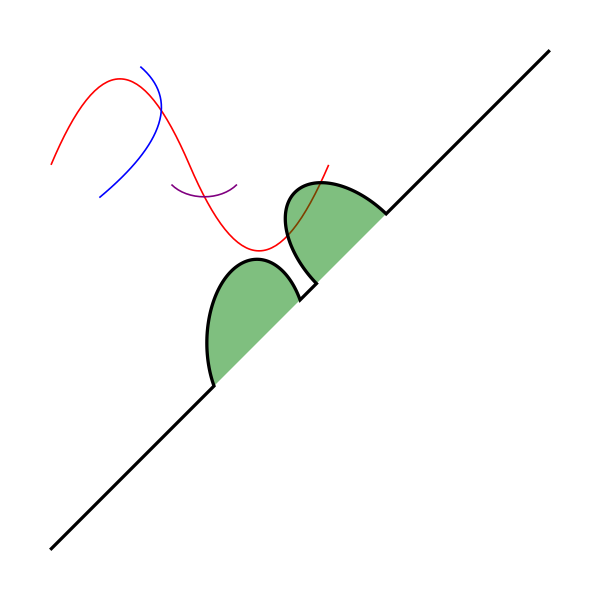

In [217]:
SVG(file)

In [218]:
attributes[0]

{'d': 'M 10.5,80.0           C 40.0,10.0 65.0,10.0 95.0,80.0           C 125.0,150.0 150.0,150.0 180.0,80.0',
 'fill': 'none',
 'stroke': 'red'}

In [219]:
def rect2path(rect):
    #rect is tuple (x, y, width, length)
    #rewrite using polygon()
    coords = [(rect[0], rect[1]), (rect[0], rect[1]+rect[3]), (rect[0]+rect[2], rect[1]+rect[3]),
              (rect[0]+rect[2], rect[1])]
    lines = []
    for i, point in enumerate(coords):
        lines.append(spt.Line(complex(*coords[i-1]), complex(*point)))
    return spt.Path(*lines)

def path2attr(rect_path):
    new_att = {}
    new_att['d'] = rect_path.d()
    new_att['fill'] = 'none'
    new_att['stroke'] = 'red'
    return new_att

In [220]:
#attributes

In [221]:
#paths[0][0]

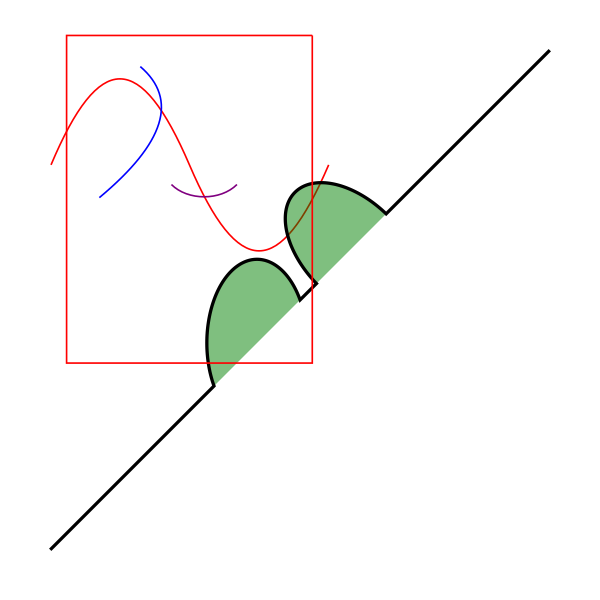

In [222]:
crop_rect = (20, 1, 150, 200)

def visualize_crop(file, crop_rect):
    crop_path = rect2path(crop_rect)
    new_attr = path2attr(crop_path)
    #rebuild SVG with red box
    paths, attributes, svg_attributes = spt.svg2paths2(file)
    paths.append(crop_path)
    attributes.append(new_attr)
    spt.wsvg(paths, attributes=attributes, svg_attributes=svg_attributes, filename='test_crop_rect.svg')
    return 'test_crop_rect.svg'

output = visualize_crop(file, crop_rect)
SVG(output)

In [223]:
paths, attributes, svg_attributes = spt.svg2paths2(output)
redpath = paths[0]
redpath_attr = attributes[0]
croppath = paths[-1]
redpath.intersect(croppath)

[((np.float64(0.05444913892702143),
   CubicBezier(start=(10.5+80j), control1=(40+10j), control2=(65+10j), end=(95+80j)),
   np.float64(0.10901851931771982)),
  (np.float64(0.29800281261380956),
   Line(start=(20+1j), end=(20+201j)),
   np.float64(0.29300984414833364))),
 ((np.float64(0.9433967955914969),
   CubicBezier(start=(95+80j), control1=(125+150j), control2=(150+150j), end=(180+80j)),
   np.float64(0.8869183140971657)),
  (np.float64(0.8570545916779949),
   Line(start=(170+201j), end=(170+1j)),
   np.float64(0.49969107087298253)))]

In [285]:
crop_rect = (20, 1, 150, 200)
croppath = rect2path(crop_rect)

#function that takes two bounding boxes and determines if the two boxes cover any of the same area. 
#box1 and box2 are lists with the format [xmin, xmax, ymin, ymax]
def boxes_overlap(box1, box2):
    #check if the boxes overlap in the x direction
    if box1[0] < box2[1] and box1[1] > box2[0]:
        #check if the boxes overlap in the y direction
        if box1[2] < box2[3] and box1[3] > box2[2]:
            return True
    return False

def dim_str2num(s):
    try:
        float(s)
        return float(s), None
    except ValueError:
        return float(s[:-2]), s[-2:]

def dim_num2str(dim, unit):
    if unit == None:
        return "{}".format(math.floor(dim))
    if unit in ['cm', 'in', 'mm']:
        return "{}{}".format(dim, unit)
    if unit == "px":
        return "{}{}".format(math.floor(dim), unit)
    else:
        print("invalid input for unit argument")

#resize SVG height and width to match cropped size
def crop_svg_attr(svg_attributes, croppath):
    #height and width dimensions are recognized as cm, mm, in, em, ex, pt, pc, and px
    cbbox = croppath.bbox() #[xmin, xmax, ymin, ymax]
    orig_vbox = [float(x) for x in svg_attributes['viewBox'].split(' ')] #[xmin, ymin, xmax, ymax]
    orig_height, height_unit = dim_str2num(svg_attributes['height'])
    orig_width, width_unit = dim_str2num(svg_attributes['width'])
    new_height = orig_height*((cbbox[3]-cbbox[2])/(orig_vbox[3]-orig_vbox[1]))
    new_width = orig_width*((cbbox[1]-cbbox[0])/(orig_vbox[2]-orig_vbox[0]))
    new_viewbox = '{} {} {} {}'.format(cbbox[0], cbbox[2], cbbox[1], cbbox[3])
    new_svg_attributes['viewBox'] = new_viewbox
    new_svg_attributes['height'] = dim_num2str(new_height, height_unit)
    new_svg_attributes['width'] = dim_num2str(new_width, width_unit)
    return new_svg_attributes
    


def crop_svg(file, croppath):
    #returns list of paths, attributes, and svg_attributes from the original file cropped to within the croppath
    paths, attributes, svg_attributes = spt.svg2paths2(file)
    tol = 0.0002
    cropped_paths = []
    cropped_attributes = []
    new_svg_attributes = crop_svg_attr(svg_attributes, croppath)
    for path, attrib in zip(paths, attributes):
        if boxes_overlap(croppath.bbox(), path.bbox()):
            if path.is_contained_by(croppath):
                cropped_paths.append(path)
                cropped_attributes.append(attrib)
            else:
                intersections = path.intersect(croppath)
                #(list[tuple[float, Curve, float]]): list of intersections, each
                #in the format ((T1, seg1, t1), (T2, seg2, t2)), where
                #self.point(T1) == seg1.point(t1) == seg2.point(t2) == other_curve.point(T2)
                if not intersections:
                    print("path {} is found to overlap but not intersect or be contained by croppath".format(path))
                intersection_points = sorted([x[0][0] for x in intersections])
                start_points = [x+tol for x in intersection_points]
                start_points.insert(0, 0)
                end_points = [x-tol for x in intersection_points]
                end_points.append(1)
                brokenpath = []
                brokenpath_failures = 0
                for start, stop in zip(start_points, end_points):
                    try:
                        brokenpath.append(path.cropped(start, stop))
                    except ValueError:
                        brokenpath_failures += 1
                for broken in brokenpath:
                    if broken.is_contained_by(croppath):
                        cropped_paths.append(broken)
                        broken_attr = attrib
                        broken_attr['d'] = broken.d()
                        cropped_attributes.append(broken_attr)
    if brokenpath_failures:
        print("intersecting paths failed to resolve {}/{} times".format(brokenpath_failures, len(brokenpath)))
    return cropped_paths, cropped_attributes, new_svg_attributes   

In [233]:
cbbox = croppath.bbox()
new_viewbox = '{}, {}, {}, {}'.format(cbbox[0], cbbox[2], cbbox[1], cbbox[3])
print(new_viewbox)
print([float(x) for x in new_viewbox.split(', ')])

20.0, 1.0, 170.0, 201.0
[20.0, 1.0, 170.0, 201.0]


In [234]:
crop_rect = (20, 1, 150, 200)
croppath = rect2path(crop_rect)

cropped_paths, cropped_attributes, new_svg_attributes = crop_svg(file, croppath)

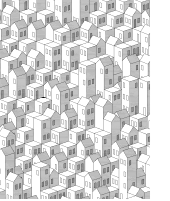

In [235]:
spt.wsvg(cropped_paths, 
         attributes=cropped_attributes, 
         svg_attributes=new_svg_attributes, filename='test_crop.svg')
SVG('test_crop.svg')

In [277]:
file = "source/Globe.svg"
paths, attributes, svg_attributes = spt.svg2paths2(file)
for a in attributes:
    a['fill'] = "none"
    a['stroke'] = "#404040"
    a['stroke-width'] = "3.0"
spt.wsvg(paths, 
         attributes=attributes, 
         svg_attributes=svg_attributes, filename='globe_rewrite.svg')
#SVG('globe_rewrite.svg')


In [278]:
svg_attributes

{'xmlns': 'http://www.w3.org/2000/svg',
 'xmlns:ev': 'http://www.w3.org/2001/xml-events',
 'xmlns:xlink': 'http://www.w3.org/1999/xlink',
 'height': '3072',
 'version': '1.1',
 'viewBox': '0 0 2316 3072',
 'width': '2316'}

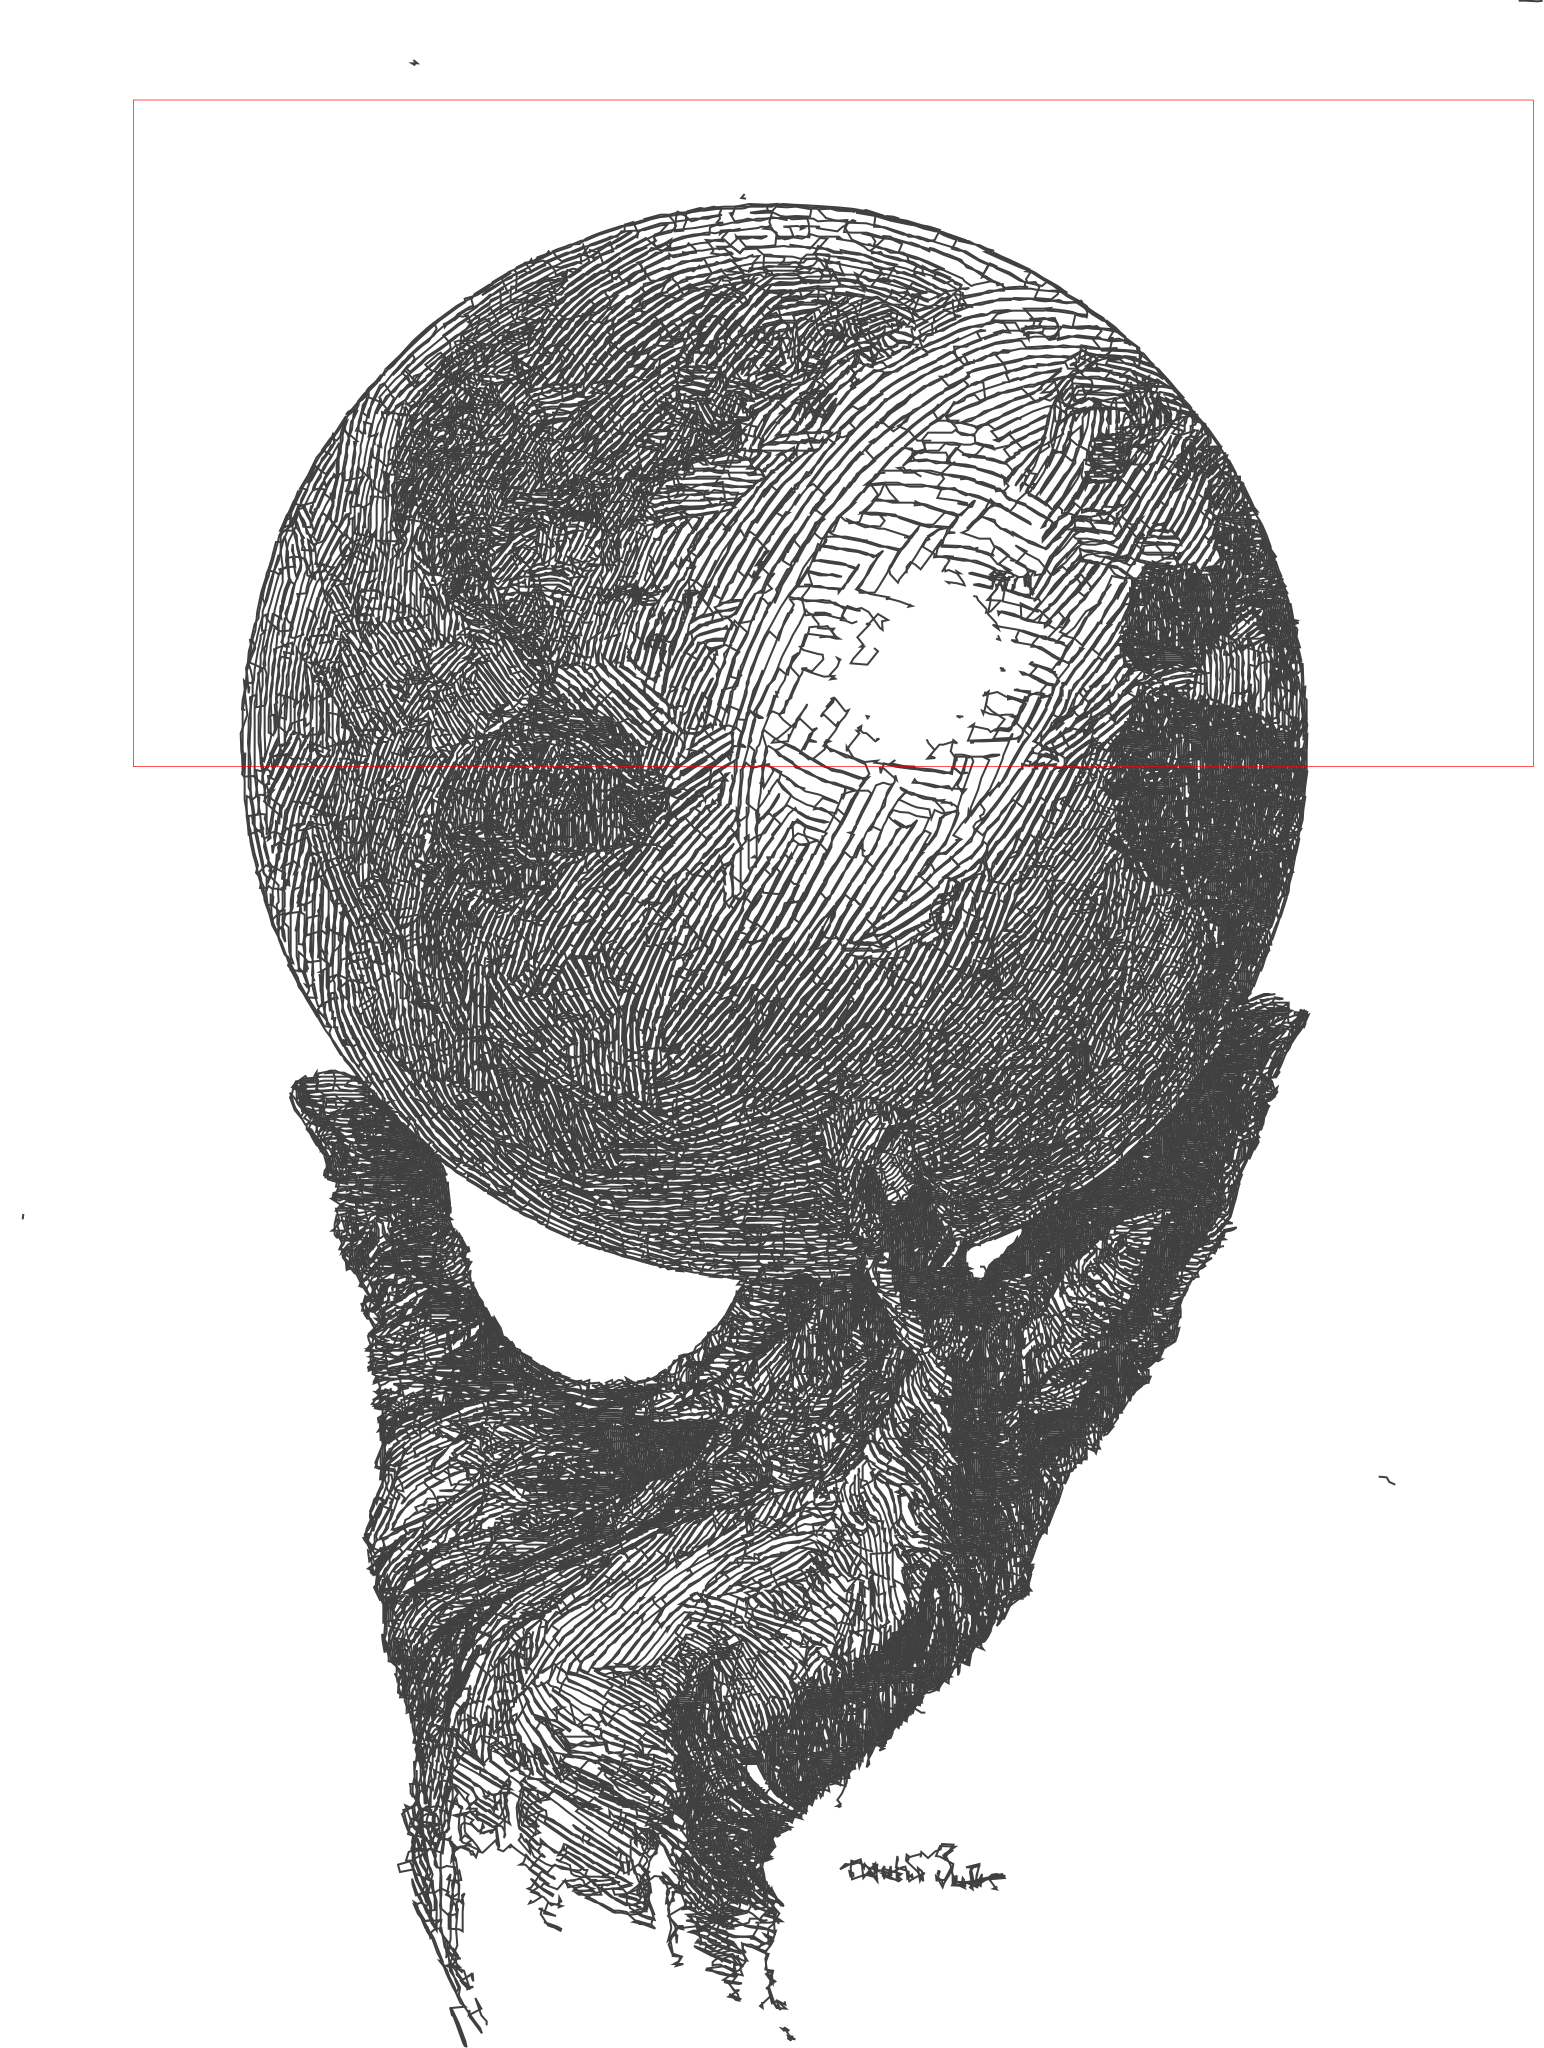

In [279]:
crop_rect = (200, 150, 2100, 1000)
crop_path = rect2path(crop_rect)
new_attr = path2attr(crop_path)
#rebuild SVG with red box
paths, attributes, svg_attributes = spt.svg2paths2(file)
for a in attributes:
    a['fill'] = "none"
    a['stroke'] = "#404040"
    a['stroke-width'] = "3.0"
paths.append(crop_path)
attributes.append(new_attr)
spt.wsvg(paths, attributes=attributes, svg_attributes=svg_attributes, filename='globe_crop_rect.svg')

SVG('globe_crop_rect.svg')

In [280]:
crop_rect = (200, 150, 2100, 1000)
croppath = rect2path(crop_rect)
cropped_paths, cropped_attributes, new_svg_attributes = crop_svg(file, croppath)
for a in cropped_attributes:
    a['fill'] = "none"
    a['stroke'] = "#404040"
    a['stroke-width'] = "3.0"

In [281]:
croppath.bbox()

(200.0, 2300.0, 150.0, 1150.0)

In [282]:
new_svg_attributes

{'xmlns': 'http://www.w3.org/2000/svg',
 'baseProfile': 'full',
 'height': '1000',
 'width': '2100',
 'version': '1.1',
 'viewBox': '200.0 150.0 2300.0 1150.0'}

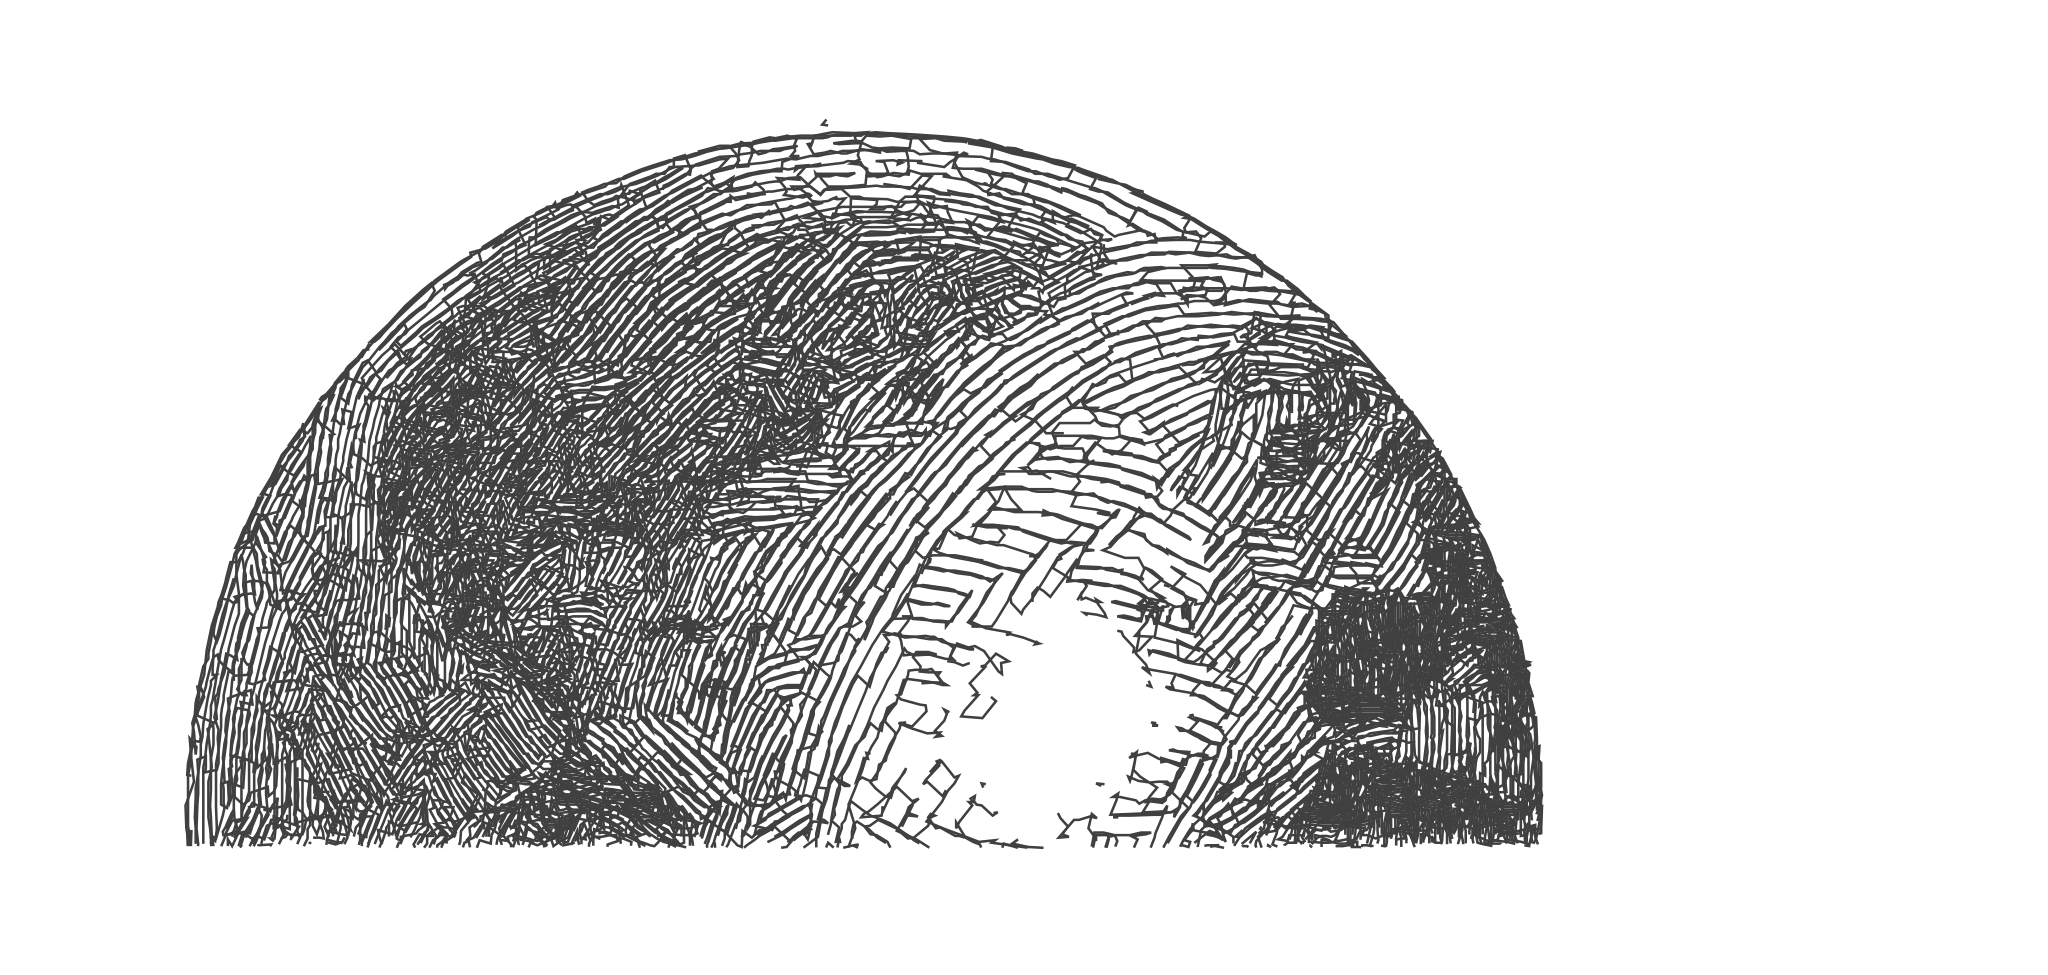

In [283]:
spt.wsvg(cropped_paths, 
         attributes=cropped_attributes, 
         svg_attributes=new_svg_attributes, filename='globe_crop.svg')
SVG('globe_crop.svg')